Processing Sparse Features: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1119.23it/s]


Epoch 1/10
1/1 - 2s - loss: 0.6801 - accuracy: 0.5213 - auc: 0.5429 - val_loss: 0.6871 - val_accuracy: 0.4894 - val_auc: 0.5495
Epoch 2/10
1/1 - 0s - loss: 0.6799 - accuracy: 0.5266 - auc: 0.5482 - val_loss: 0.6869 - val_accuracy: 0.4894 - val_auc: 0.5506
Epoch 3/10
1/1 - 0s - loss: 0.6796 - accuracy: 0.5266 - auc: 0.5493 - val_loss: 0.6868 - val_accuracy: 0.4894 - val_auc: 0.5523
Epoch 4/10
1/1 - 0s - loss: 0.6794 - accuracy: 0.5266 - auc: 0.5507 - val_loss: 0.6866 - val_accuracy: 0.5106 - val_auc: 0.5528
Epoch 5/10
1/1 - 0s - loss: 0.6792 - accuracy: 0.5266 - auc: 0.5518 - val_loss: 0.6865 - val_accuracy: 0.5106 - val_auc: 0.5536
Epoch 6/10
1/1 - 0s - loss: 0.6789 - accuracy: 0.5266 - auc: 0.5529 - val_loss: 0.6863 - val_accuracy: 0.5106 - val_auc: 0.5544
Epoch 7/10
1/1 - 0s - loss: 0.6787 - accuracy: 0.5266 - auc: 0.5539 - val_loss: 0.6862 - val_accuracy: 0.5106 - val_auc: 0.5552
Epoch 8/10
1/1 - 0s - loss: 0.6785 - accuracy: 0.5319 - auc: 0.5544 - val_loss: 0.6860 - val_accuracy: 0

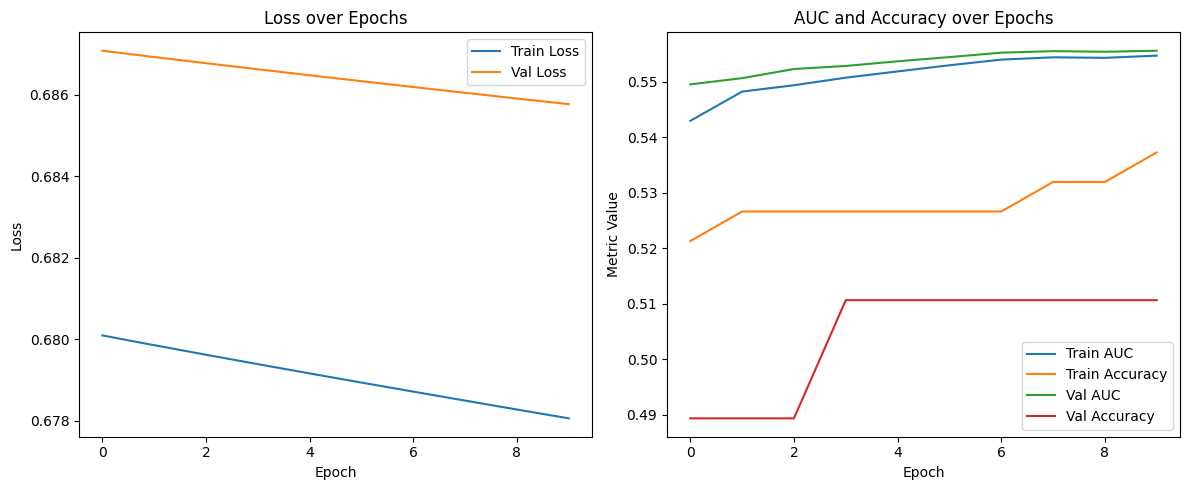

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, DenseFeat, get_feature_names
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from tqdm import tqdm
from tensorflow import keras


# === 1. 数值特征处理 ===
def process_dense_feats(data, feats):
    """
    使用 StandardScaler 对数值特征进行标准化处理。
    """
    data[feats] = data[feats].fillna(0)
    scaler = StandardScaler()
    data[feats] = scaler.fit_transform(data[feats])
    return data


# === 2. 稀疏特征处理 ===
def process_sparse_feats(data, feats):
    """
    对稀疏特征进行填充缺失并编码为整数索引。
    """
    for f in tqdm(feats, desc='Processing Sparse Features'):
        label_encoder = LabelEncoder()
        data[f] = label_encoder.fit_transform(data[f].astype(str))
    return data


# === 3. 变长序列特征处理 ===
def process_sequence_feats(data, sequence_features):
    """
    对变长特征使用自定义 Tokenizer 分词，并进行 padding 处理。
    """
    pad_sequences_dict = {}
    tokenizers = {}
    pad_len_dict = {}

    for feature in sequence_features:
        texts = data[feature].fillna("").apply(lambda x: x.replace('|', ' ')).tolist()
        tokenizer = Tokenizer(oov_token='OOV')
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, padding='post')
        pad_sequences_dict[feature] = padded
        tokenizers[feature] = tokenizer
        pad_len_dict[feature] = padded.shape[1]

    return pad_sequences_dict, tokenizers, pad_len_dict


def main():
    # === 4. 读取数据 ===
    column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel", "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
    data = pd.read_csv(r"D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\train_2.csv", sep='\t', names=column_names)

    # 特征定义
    sparse_feats = ["uid", "user_city", "item_id", "author_id", "item_city", "channel", "music_id", "device"]
    dense_feats = ["time", "duration_time"]
    sequence_feats = ['actors', 'genres']
    target = ['finish']  # 推荐任务目标

    # === 5. 特征处理 ===
    data = process_dense_feats(data, dense_feats)
    data = process_sparse_feats(data, sparse_feats)
    pad_sequences_dict, tokenizers, pad_len_dict = process_sequence_feats(data, sequence_feats) if sequence_feats else ({}, {}, {})

    # === 6. 构建特征列 ===
    fixlen_feature_columns = [
        SparseFeat(feat, data[feat].nunique() + 1, embedding_dim=4) for feat in sparse_feats
    ] + [
        DenseFeat(feat, 1) for feat in dense_feats
    ]

    # 添加变长序列特征列
    if sequence_feats:
        for feat in sequence_feats:
            fixlen_feature_columns.append(
                VarLenSparseFeat(SparseFeat(feat, vocabulary_size=len(tokenizers[feat].word_index) + 1, embedding_dim=4),
                                 maxlen=pad_len_dict[feat], combiner='mean')
            )

    linear_feature_columns = fixlen_feature_columns
    dnn_feature_columns = fixlen_feature_columns
    fixlen_feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # === 7. 划分训练集和测试集 ===
    train, test = train_test_split(data, test_size=0.2, random_state=2018)

    # 构建模型输入
    train_model_input = {name: train[name] for name in fixlen_feature_names}
    test_model_input = {name: test[name] for name in fixlen_feature_names}

    # 添加序列特征到输入
    if sequence_feats:
        for feat in sequence_feats:
            train_model_input[feat] = pad_sequences_dict[feat][train.index]
            test_model_input[feat] = pad_sequences_dict[feat][test.index]

    # === 8. 构建和训练 DeepFM 模型 ===
    model = DeepFM(
        linear_feature_columns=linear_feature_columns,
        dnn_feature_columns=dnn_feature_columns,
        task='binary'
    )
    model.compile("adagrad", "binary_crossentropy", metrics=["accuracy", keras.metrics.AUC(name='auc')])

    history = model.fit(
        train_model_input,
        train[target].values,
        batch_size=256,
        epochs=10,
        verbose=2,
        validation_split=0.2
    )

    # === 9. 模型评估 ===
    pred_ans = model.predict(test_model_input, batch_size=256)
    print("Test LogLoss:", round(log_loss(test[target].values, pred_ans, labels=[0, 1]), 4))
    print("Test AUC:", round(roc_auc_score(test[target].values, pred_ans), 4))

    # === 10. 可视化训练过程 ===
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['loss'], label='Train Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, history.history['auc'], label='Train AUC')
    plt.plot(history.epoch, history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.epoch, history.history['val_auc'], label='Val AUC')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('AUC and Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [71]:
train.index

Int64Index([118, 266, 120, 212, 282,  66, 169, 255, 170,  53,
            ...
             75,  87, 153,  25, 148, 156, 265, 226, 102, 250],
           dtype='int64', length=235)

In [72]:
pad_sequences_dict["actors"][train.index]

array([[2, 7],
       [7, 6],
       [3, 2],
       [8, 5],
       [8, 0],
       [7, 0],
       [2, 0],
       [2, 0],
       [6, 4],
       [2, 7],
       [9, 0],
       [4, 0],
       [9, 0],
       [2, 4],
       [9, 0],
       [7, 3],
       [5, 0],
       [2, 0],
       [2, 4],
       [5, 0],
       [6, 4],
       [2, 9],
       [7, 3],
       [5, 7],
       [7, 5],
       [3, 0],
       [5, 0],
       [4, 0],
       [6, 5],
       [7, 3],
       [3, 0],
       [8, 4],
       [2, 4],
       [6, 8],
       [6, 0],
       [4, 7],
       [2, 0],
       [9, 0],
       [2, 0],
       [2, 0],
       [8, 9],
       [3, 2],
       [8, 0],
       [8, 0],
       [5, 2],
       [4, 0],
       [9, 2],
       [4, 3],
       [8, 0],
       [8, 3],
       [3, 0],
       [2, 0],
       [6, 0],
       [7, 6],
       [6, 3],
       [2, 5],
       [7, 0],
       [4, 9],
       [3, 0],
       [6, 0],
       [2, 5],
       [2, 0],
       [5, 9],
       [5, 0],
       [9, 0],
       [8, 7],
       [5,

In [67]:
train

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
118,90,0,74,107,99,1,0,0,0,144,0.268501,-0.251331,"动作,爱情",刘德华
266,196,83,156,209,31,0,0,0,0,87,0.467451,0.311651,"爱情,剧情","周星驰,舒淇"
120,121,95,76,5,84,0,1,0,76,120,0.500373,-0.392077,"悬疑,动作","马特·达蒙,张学友"
212,275,124,123,1,10,0,1,0,0,9,0.509060,-0.532823,"惊悚,战争",小李子
282,143,105,192,72,102,0,0,0,91,239,0.454497,-0.251331,惊悚,"马特·达蒙,李连杰"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,117,34,89,44,0,0,0,0,0,164,0.495626,0.030160,"爱情,剧情","周星驰,马特·达蒙"
265,247,110,155,138,30,0,0,0,54,158,-0.743684,0.311651,动作,李连杰
226,53,87,133,237,110,0,1,0,102,98,0.443303,-0.251331,"动作,喜剧","巩俐,刘德华"
102,126,109,64,94,103,0,0,0,0,147,0.366021,-0.392077,"剧情,悬疑","张学友,成龙"


In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, DenseFeat, get_feature_names
from sklearn.model_selection import train_test_split
from tqdm import tqdm



# 定义稀疏特征的函数，返回特征名和特征可能的取值数量
def sparse_feat(feat, feat_num):
    """
    构建稀疏特征的字典。
    """
    return {'feat': feat, 'feat_num': feat_num}


# 定义数值特征的函数，返回特征名
def dense_feat(feat):
    """
    构建数值特征的字典。
    """
    return {'feat': feat}


# 处理数值特征
def process_dense_feats(data, feats):
    """
    使用 StandardScaler 对数值特征进行标准化处理。
    """
    data[feats] = data[feats].fillna(0)
    scaler = StandardScaler()
    data[feats] = scaler.fit_transform(data[feats])
    return data


# 处理稀疏特征，填充缺失值并编码
def process_sparse_feats(data, feats):
    """
    对稀疏特征进行处理，填充缺失值并使用 Label Encoding 编码。
    """
    for f in tqdm(feats, desc='process_sparse_feats'):
        label_encoder = LabelEncoder()  # 创建 LabelEncoder 实例
        data[f] = label_encoder.fit_transform(data[f])  # 编码特征
    return data


# 处理变长序列特征
# 处理变长序列特征
def process_sequence_feats(data, sequence_features):
	# 用于存储每个变长特征处理后的 padding 序列
	pad_sequences_dict = {}

	# 每个变长特征对应一个独立的 Tokenizer，用于后续文本转索引
	tokenizers = {}

	# 用于记录每个变长特征的 padding 长度（即序列被填充后的最大长度）
	pad_len_dict = {}
	
	# 遍历所有变长序列特征
	for feature in sequence_features:
		texts = data[feature].apply(lambda x: x.replace('|', ' ')).tolist()
		tokenizer = Tokenizer(oov_token='OOV')
		tokenizer.fit_on_texts(texts)
		sequences = tokenizer.texts_to_sequences(texts)
		padded = pad_sequences(sequences, padding='post')  # shape: (num_samples, max_seq_len)
		pad_sequences_dict[feature] = padded
		tokenizers[feature] = tokenizer
		pad_len_dict[feature] = padded.shape[1]  # 保存每个特征的序列长度（max_seq_len）
    
	return pad_sequences_dict,tokenizer,pad_len_dict


# 定义拆分函数
def split(x, key2index):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [33]:
column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel", "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
data = pd.read_csv(r"D:\software\pycharm_repository\StarMaker\MultiRecSys\data_files\train_2.csv", sep='\t', names=column_names)  # 大数据集
print(data.head(5))

     uid  user_city  item_id  author_id  item_city  channel  finish  like  \
0  57384         52    43192     142828          0        0       0     0   
1   3230          5    46822     231026          1        0       1     0   
2   1249        328  1209078     456220          2        0       0     0   
3  11928          8  1209079     456221          3        0       0     0   
4  51266         89  1209080     126416          4        0       1     0   

   music_id  device         time  duration_time actors     genres  
0      4513   34178  53085993699             39     喜剧        刘德华  
1      5330   24878  53086372896             16  惊悚,爱情        小李子  
2     39979   14274  53086458433              4  爱情,悬疑     李连杰,成龙  
3        -1   16649  53086463774              9  战争,剧情  李连杰,汤姆·哈迪  
4        -1   27090  53086432937             19     剧情      巩俐,舒淇  


In [34]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,57384,52,43192,142828,0,0,0,0,4513,34178,53085993699,39,喜剧,刘德华
1,3230,5,46822,231026,1,0,1,0,5330,24878,53086372896,16,"惊悚,爱情",小李子
2,1249,328,1209078,456220,2,0,0,0,39979,14274,53086458433,4,"爱情,悬疑","李连杰,成龙"
3,11928,8,1209079,456221,3,0,0,0,-1,16649,53086463774,9,"战争,剧情","李连杰,汤姆·哈迪"
4,51266,89,1209080,126416,4,0,1,0,-1,27090,53086432937,19,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,30928,30,1209236,15497,134,0,1,0,2219,34737,53084398120,21,"爱情,悬疑",巩俐
290,4112,-1,1209237,41018,125,1,0,0,-1,500,53086200656,9,战争,"汤姆·哈迪,舒淇"
291,3407,99,1209238,38830,14,0,0,0,-1,22465,53083946541,17,"惊悚,科幻","周星驰,张学友"
292,52039,292,86024,2793,60,0,1,0,-1,28869,53086431733,10,"动作,惊悚",汤姆·哈迪


In [35]:
# 区分数值特征和稀疏特征
sparse_feats  = ["uid", "user_city", "item_id", "author_id", "item_city", "channel", "music_id", "device"]
dense_feats   = ["time", "duration_time"]
sequence_feats = ['actors', 'genres']  # 有的时候可能为空列表 []

In [36]:
# 处理数值特征、稀疏特征和序列特征
data = process_dense_feats(data, dense_feats)
data = process_sparse_feats(data, sparse_feats)
if sequence_feats:
    pad_sequences_dict,tokenizer,pad_len_dict = process_sequence_feats(data, sequence_feats)
else:
    tokenizers = {}

process_sparse_feats: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 4008.41it/s]


In [39]:
for key,value in pad_sequences_dict.items():
    print(key,value.shape)

actors (294, 2)
genres (294, 2)


In [40]:
tokenizer

In [41]:
pad_len_dict

{'actors': 2, 'genres': 2}

In [42]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,259,31,26,210,1,0,0,0,82,202,0.250521,3.830290,喜剧,刘德华
1,24,4,27,244,2,0,1,0,85,151,0.467755,0.593142,"惊悚,爱情",小李子
2,10,126,130,265,3,0,0,0,113,97,0.516757,-1.095805,"爱情,悬疑","李连杰,成龙"
3,90,6,131,266,4,0,0,0,0,112,0.519817,-0.392077,"战争,剧情","李连杰,汤姆·哈迪"
4,242,50,132,202,5,0,1,0,0,155,0.502151,1.015379,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,155,20,288,79,134,0,1,0,62,206,-0.663550,1.296870,"爱情,悬疑",巩俐
290,33,0,289,125,125,1,0,0,0,3,0.369082,-0.392077,战争,"汤姆·哈迪,舒淇"
291,29,53,290,121,15,0,0,0,0,144,-0.922249,0.733888,"惊悚,科幻","周星驰,张学友"
292,246,121,40,25,60,0,1,0,0,165,0.501461,-0.251331,"动作,惊悚",汤姆·哈迪


In [ ]:
# 8. 构建 DeepCTR 所需的特征列
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4) for feat in sparse_feats] + [DenseFeat(feat, 1) for feat in dense_features]

In [43]:
sparse_feats

['uid',
 'user_city',
 'item_id',
 'author_id',
 'item_city',
 'channel',
 'music_id',
 'device']

In [44]:
dense_feats

['time', 'duration_time']

In [45]:
sequence_feats

['actors', 'genres']

In [46]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,259,31,26,210,1,0,0,0,82,202,0.250521,3.830290,喜剧,刘德华
1,24,4,27,244,2,0,1,0,85,151,0.467755,0.593142,"惊悚,爱情",小李子
2,10,126,130,265,3,0,0,0,113,97,0.516757,-1.095805,"爱情,悬疑","李连杰,成龙"
3,90,6,131,266,4,0,0,0,0,112,0.519817,-0.392077,"战争,剧情","李连杰,汤姆·哈迪"
4,242,50,132,202,5,0,1,0,0,155,0.502151,1.015379,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,155,20,288,79,134,0,1,0,62,206,-0.663550,1.296870,"爱情,悬疑",巩俐
290,33,0,289,125,125,1,0,0,0,3,0.369082,-0.392077,战争,"汤姆·哈迪,舒淇"
291,29,53,290,121,15,0,0,0,0,144,-0.922249,0.733888,"惊悚,科幻","周星驰,张学友"
292,246,121,40,25,60,0,1,0,0,165,0.501461,-0.251331,"动作,惊悚",汤姆·哈迪


In [47]:
# 8. 构建 DeepCTR 所需的特征列
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4) for feat in sparse_feats] + [DenseFeat(feat, 1) for feat in dense_feats]

In [48]:
fixlen_feature_columns

[SparseFeat(name='uid', vocabulary_size=289, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001EC0F403C10>, embedding_name='uid', group_name='default_group', trainable=True),
 SparseFeat(name='user_city', vocabulary_size=129, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001EC0F403D00>, embedding_name='user_city', group_name='default_group', trainable=True),
 SparseFeat(name='item_id', vocabulary_size=291, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001EC0F403DF0>, embedding_name='item_id', group_name='default_group', trainable=True),
 SparseFeat(name='author_id', vocabulary_size=289, embedding_dim=4, use

In [50]:
if sequence_feats:
    for feat in sequence_feats:
        fixlen_feature_columns.append(VarLenSparseFeat(SparseFeat(feat, vocabulary_size=len(tokenizers[feat].word_index) + 1, embedding_dim=4), maxlen=pad_len_dict[feat], combiner='mean',
                                               weight_name=None))

In [51]:
fixlen_feature_columns

[SparseFeat(name='uid', vocabulary_size=289, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001EC0F403C10>, embedding_name='uid', group_name='default_group', trainable=True),
 SparseFeat(name='user_city', vocabulary_size=129, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001EC0F403D00>, embedding_name='user_city', group_name='default_group', trainable=True),
 SparseFeat(name='item_id', vocabulary_size=291, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001EC0F403DF0>, embedding_name='item_id', group_name='default_group', trainable=True),
 SparseFeat(name='author_id', vocabulary_size=289, embedding_dim=4, use

In [53]:
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns 

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [54]:
feature_names

['uid',
 'user_city',
 'item_id',
 'author_id',
 'item_city',
 'channel',
 'music_id',
 'device',
 'time',
 'duration_time',
 'actors',
 'genres']

In [56]:
# 3.generate input data for model
model_input = {name: data[name] for name in feature_names}  #

In [58]:
for key,value in model_input.items():
    print(key,value)

uid 0      259
1       24
2       10
3       90
4      242
      ... 
289    155
290     33
291     29
292    246
293    232
Name: uid, Length: 294, dtype: int64
user_city 0       31
1        4
2      126
3        6
4       50
      ... 
289     20
290      0
291     53
292    121
293     16
Name: user_city, Length: 294, dtype: int64
item_id 0       26
1       27
2      130
3      131
4      132
      ... 
289    288
290    289
291    290
292     40
293     23
Name: item_id, Length: 294, dtype: int64
author_id 0      210
1      244
2      265
3      266
4      202
      ... 
289     79
290    125
291    121
292     25
293    147
Name: author_id, Length: 294, dtype: int64
item_city 0        1
1        2
2        3
3        4
4        5
      ... 
289    134
290    125
291     15
292     60
293    135
Name: item_city, Length: 294, dtype: int64
channel 0      0
1      0
2      0
3      0
4      0
      ..
289    0
290    1
291    0
292    0
293    0
Name: channel, Length: 294, dtype: int6

In [ ]:
model_input["genres"] = genres_list

In [59]:
for name in sequence_feats:
    model_input[name] = pad_sequences_dict[name]

In [60]:
model_input

{'uid': 0      259
 1       24
 2       10
 3       90
 4      242
       ... 
 289    155
 290     33
 291     29
 292    246
 293    232
 Name: uid, Length: 294, dtype: int64,
 'user_city': 0       31
 1        4
 2      126
 3        6
 4       50
       ... 
 289     20
 290      0
 291     53
 292    121
 293     16
 Name: user_city, Length: 294, dtype: int64,
 'item_id': 0       26
 1       27
 2      130
 3      131
 4      132
       ... 
 289    288
 290    289
 291    290
 292     40
 293     23
 Name: item_id, Length: 294, dtype: int64,
 'author_id': 0      210
 1      244
 2      265
 3      266
 4      202
       ... 
 289     79
 290    125
 291    121
 292     25
 293    147
 Name: author_id, Length: 294, dtype: int64,
 'item_city': 0        1
 1        2
 2        3
 3        4
 4        5
       ... 
 289    134
 290    125
 291     15
 292     60
 293    135
 Name: item_city, Length: 294, dtype: int64,
 'channel': 0      0
 1      0
 2      0
 3      0
 4      0
     

In [64]:
# 4.Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['accuracy'], )
history = model.fit(model_input, data['like'].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10
1/1 - 2s - loss: 0.4617 - accuracy: 0.9191 - val_loss: 0.6868 - val_accuracy: 0.9661
Epoch 2/10
1/1 - 0s - loss: 0.3466 - accuracy: 0.9660 - val_loss: 0.5345 - val_accuracy: 0.9661
Epoch 3/10
1/1 - 0s - loss: 0.2591 - accuracy: 0.9915 - val_loss: 0.4063 - val_accuracy: 1.0000
Epoch 4/10
1/1 - 0s - loss: 0.1901 - accuracy: 0.9957 - val_loss: 0.3061 - val_accuracy: 1.0000
Epoch 5/10
1/1 - 0s - loss: 0.1390 - accuracy: 0.9957 - val_loss: 0.2205 - val_accuracy: 1.0000
Epoch 6/10
1/1 - 0s - loss: 0.0970 - accuracy: 0.9957 - val_loss: 0.1488 - val_accuracy: 1.0000
Epoch 7/10
1/1 - 0s - loss: 0.0634 - accuracy: 0.9957 - val_loss: 0.0919 - val_accuracy: 1.0000
Epoch 8/10
1/1 - 0s - loss: 0.0386 - accuracy: 0.9957 - val_loss: 0.0491 - val_accuracy: 1.0000
Epoch 9/10
1/1 - 0s - loss: 0.0230 - accuracy: 0.9957 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 10/10
1/1 - 0s - loss: 0.0164 - accuracy: 0.9957 - val_loss: 0.0077 - val_accuracy: 1.0000
